In [1]:
import warnings
import pandas as pd
import numpy as np
import srt

In [2]:
#where do we need to read our data from
fileName = "httpsaudio1.redcircle.comepisodes2f8c0bc9a240433d934c8971d8da0a6cstream.mp3.srt"
prosodyPath = "/shared/3/projects/benlitterer/podcastData/prosody/premadeTransProsody"
diarizePath = "/shared/3/projects/benlitterer/podcastData/diarization/premadeTransDiarized"
transcriptPath = "/shared/3/projects/benlitterer/podcastData/transcripts/premadeTransTranscripts"

In [3]:
prosodyDf = pd.read_csv(f'{prosodyPath}/{fileName.replace(".srt", "LowLevel.csv")}')

In [4]:
def addMicroseconds(inStr): 
    if "." not in inStr: 
        return inStr + ".000000"
    else: 
        return inStr

prosodyDf["start"] = prosodyDf["start"].apply(addMicroseconds)
prosodyDf["end"] = prosodyDf["end"].apply(addMicroseconds)

In [5]:
#get columns to datetime format 
prosodyDf["start"] = prosodyDf["start"].apply(lambda x: x.split(" ")[2])
prosodyDf["start"] = pd.to_datetime(prosodyDf["start"], format="%H:%M:%S.%f")
prosodyDf["end"] = prosodyDf["end"].apply(lambda x: x.split(" ")[2])
prosodyDf["end"] = pd.to_datetime(prosodyDf["end"], format="%H:%M:%S.%f")


In [6]:
#get seconds that have passed in podcast 
prosodyDf["end"] = (prosodyDf["end"] - prosodyDf.loc[0, "start"]).dt.total_seconds()
prosodyDf["start"] = (prosodyDf["start"] - prosodyDf.loc[0, "start"]).dt.total_seconds()

In [7]:
#remove overlapping time chunks 
prosodyDf = prosodyDf[prosodyDf.index % 2 == 0].reset_index(drop=True)

In [8]:
cols=["d1", "fPath", "d2", "start", "duration", "d3", "d4", "speaker", "d5", "d6"]
diarizeDf = pd.read_csv(f'{diarizePath}/{fileName.replace("srt", "rttm")}', sep=" ", names=cols)

In [9]:
diarizeDf["end"] = diarizeDf["start"] + diarizeDf["duration"]

In [10]:
diarizeDf = diarizeDf[["start", "duration", "end", "speaker"]]

#we map who is speaking on to each token, 
#so if there's overlap we account for this 
diarizeDf

,start,duration,end,speaker
0,3.814,33.840,37.654,SPEAKER_01
1,42.090,41.143,83.233,SPEAKER_01
2,49.684,4.317,54.001,SPEAKER_00
3,68.046,0.171,68.217,SPEAKER_00
4,70.896,0.171,71.067,SPEAKER_00
...,...,...,...,...
69,909.582,0.205,909.787,SPEAKER_01
70,913.985,2.628,916.613,SPEAKER_01
71,916.817,2.969,919.786,SPEAKER_00
72,919.275,1.399,920.674,SPEAKER_01


In [11]:
transcriptPath = "/shared/3/projects/benlitterer/podcastData/transcripts/premadeTransTranscripts" 
transcriptFile = open(f"{transcriptPath}/{fileName}") 

transcript = transcriptFile.read() 
transTokens = srt.parse(transcript)

transcriptList = []

for tok in transTokens: 
    transcriptList.append([tok.start, tok.end, tok.content])

In [12]:
transcriptDf = pd.DataFrame(transcriptList, columns=["start", "end", "content"])

In [13]:
transcriptDf["start"] = transcriptDf["start"].dt.total_seconds()
transcriptDf["end"] = transcriptDf["end"].dt.total_seconds()

In [14]:
transcriptDf = transcriptDf.reset_index()

In [15]:
#at what speaker tag do we start considering 
#who was speaking 
fSpeaker = 0

allTokSpeakers = []
speakerList = diarizeDf[["start", "end", "speaker"]].values.tolist()

for tokIndex, tokStart, tokEnd in transcriptDf[["index", "start", "end"]].values.tolist(): 
    
    #set our speaker index to the first speaker we need to consider
    speakerIndex = fSpeaker
    speakStart = speakerList[speakerIndex][0]
    speakEnd = speakerList[speakerIndex][1]
    currSpeaker = speakerList[speakerIndex][2]

    tokSpeakers = []
    #only consider speech from speakers which starts 
    #before the token ends 
    while speakStart < tokEnd: 

        #if the current speaker finishes before the token, 
        #we can start at the next speaker when considering the next token
        #TODO: fix bug here... 
        if speakEnd < tokEnd: 
            #fSpeaker += 1
            #^doesn't do what we want
            pass
        
        #if the speaker is speaking at any point overlapping with this token 
        if tokStart < speakEnd: 
            tokSpeakers.append(currSpeaker)
        
        #now consider next speaker in order of start time 
        speakerIndex += 1
        
        #exit if we've hit the last speaker 
        if speakerIndex == len(speakerList): 
            break
            
        speakStart = speakerList[speakerIndex][0]
        speakEnd = speakerList[speakerIndex][1]
        currSpeaker = speakerList[speakerIndex][2]
        
    allTokSpeakers.append(",".join(tokSpeakers))
        

In [16]:
len(allTokSpeakers)

4011

In [17]:
transcriptDf["speaker"] = allTokSpeakers

In [18]:
transcriptDf.head(4)

,index,start,end,content,speaker
0,0,0.00,3.01,,
1,1,3.01,4.08,Welcome,SPEAKER_01
2,2,4.08,4.26,to,SPEAKER_01
3,3,4.26,4.53,the,SPEAKER_01


In [19]:
prosList = prosodyDf.values.tolist()

In [20]:
#probably just want averages but keep the actual prosody values just in case 
allProsAvgs = []
allProsVals = []

prosIndex = 0
prosStart = prosList[prosIndex][0]
prosEnd = prosList[prosIndex][1]
prosMid = (prosStart + prosEnd)/2.0
prosVals = prosList[prosIndex][2:]
    
for tokIndex, tokStart, tokEnd in transcriptDf[["index", "start", "end"]].values.tolist(): 

    
    #this is where the current prosody values go 
    currProsVals = [[] for i in range(len(prosVals))]
    
    #keep adding prosody values until the midpoint of the prosody interval 
    #is PAST the end of the token interval 
    while prosMid < tokEnd:
        
        #for each prosody value, append it to appropriate list 
        for i, prosVal in enumerate(prosVals): 
            currProsVals[i].append(prosVal)
            
        prosIndex += 1
        
        #if we hit the end of the loop exit 
        if prosIndex >= len(prosList): 
            break
            
        prosStart = prosList[prosIndex][0]
        prosEnd = prosList[prosIndex][1]
        prosMid = (prosStart + prosEnd)/2.0
        prosVals = prosList[prosIndex][2:]
    allProsVals.append(currProsVals)
    

In [21]:
len(transcriptDf)

4011

In [22]:
len(allProsVals)

4011

In [23]:
prosodyGrouped = pd.DataFrame(allProsVals, columns=list(prosodyDf.columns)[2:])
#prosodyAvgd = pd.DataFrame(allProsAvgs, columns=list(prosodyDf.columns)[2:])

In [24]:
# block supresses the warnings from invalid values and taking mean/median of empty list 
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    prosodyAvgd = prosodyGrouped.applymap(np.mean)
    prosodyMedianed = prosodyGrouped.applymap(np.median)

In [25]:
transcriptDf[list(prosodyDf.columns)[2:]] = prosodyAvgd

In [26]:
#NOTE: the transcript df will occasionally give us tokens for which there is zero time passing
#this means we don't get any prosody values there 
transcriptDf[transcriptDf.isnull().any(axis=1)].head(4)

,index,start,end,content,speaker,Loudness_sma3,alphaRatio_sma3,hammarbergIndex_sma3,slope0-500_sma3,slope500-1500_sma3,...,logRelF0-H1-A3_sma3nz,F1frequency_sma3nz,F1bandwidth_sma3nz,F1amplitudeLogRelF0_sma3nz,F2frequency_sma3nz,F2bandwidth_sma3nz,F2amplitudeLogRelF0_sma3nz,F3frequency_sma3nz,F3bandwidth_sma3nz,F3amplitudeLogRelF0_sma3nz
100,100,29.80,29.80,,SPEAKER_01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221,221,58.80,58.80,,SPEAKER_01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
285,285,75.21,75.21,so,SPEAKER_01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
287,287,75.64,75.64,.,SPEAKER_01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
#fill na values with the previous row (probably reasonable in this case)
transcriptDf = transcriptDf.fillna(method="ffill")

In [28]:
transcriptDf

,index,start,end,content,speaker,Loudness_sma3,alphaRatio_sma3,hammarbergIndex_sma3,slope0-500_sma3,slope500-1500_sma3,...,logRelF0-H1-A3_sma3nz,F1frequency_sma3nz,F1bandwidth_sma3nz,F1amplitudeLogRelF0_sma3nz,F2frequency_sma3nz,F2bandwidth_sma3nz,F2amplitudeLogRelF0_sma3nz,F3frequency_sma3nz,F3bandwidth_sma3nz,F3amplitudeLogRelF0_sma3nz
0,0,0.00,3.01,,,0.070944,-9.994163,16.936616,0.069551,0.016665,...,5.952404,580.875059,1269.034358,-109.487481,1422.842826,1105.089978,-113.498291,2309.041167,918.158312,-116.851814
1,1,3.01,4.08,Welcome,SPEAKER_01,0.278749,-10.959667,20.824392,0.064268,-0.003413,...,16.167099,744.916366,1415.117352,-32.354739,1687.546430,1213.548776,-36.544506,2742.048154,1046.036905,-44.715856
2,2,4.08,4.26,to,SPEAKER_01,0.685211,-21.770105,31.839082,0.054349,-0.002845,...,24.048519,719.127362,1253.540900,-20.459043,1752.237856,914.896911,-25.866791,2865.388056,823.562913,-32.420979
3,3,4.26,4.53,the,SPEAKER_01,0.614206,-19.321967,28.350964,0.014746,-0.007523,...,21.460244,660.734762,1272.322014,-40.839024,1808.069979,1017.161767,-59.744327,2831.929071,1019.920157,-58.640195
4,4,4.53,4.64,Ab,SPEAKER_01,1.889319,-7.502330,20.957684,0.018565,-0.030620,...,20.308926,440.443358,1289.198960,-9.765162,1313.680100,1017.488200,-7.528546,2527.683700,755.180308,-23.055253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4006,4006,920.24,920.53,Thank,SPEAKER_01,0.633231,-11.521681,16.417889,0.007597,-0.011756,...,18.014870,415.602456,1246.454296,-9.531104,1489.113071,782.402679,-23.151708,2426.301929,845.004582,-17.787899
4007,4007,920.53,920.70,you,"SPEAKER_01,SPEAKER_00",0.077023,-30.225518,39.273265,-0.026636,0.009334,...,26.270019,818.880993,1504.346344,-102.303728,1879.953722,1270.559656,-108.263114,2946.358211,1205.993600,-111.474561
4008,4008,920.70,920.81,so,SPEAKER_00,0.377074,-19.037082,26.571126,0.036812,-0.020976,...,13.773496,657.040308,1402.996760,-20.256963,1669.569300,1481.607990,-26.683960,2683.271560,849.544180,-28.618685
4009,4009,920.81,921.04,much,SPEAKER_00,0.644226,-6.610675,11.739614,0.042891,-0.009656,...,1.918804,659.028673,1165.395445,-43.343105,1755.513117,1079.232739,-50.204670,2643.122817,1362.951608,-44.887573


In [31]:
transcriptDf.columns

Index(['index', 'start', 'end', 'content', 'speaker', 'Loudness_sma3',
       'alphaRatio_sma3', 'hammarbergIndex_sma3', 'slope0-500_sma3',
       'slope500-1500_sma3', 'spectralFlux_sma3', 'mfcc1_sma3', 'mfcc2_sma3',
       'mfcc3_sma3', 'mfcc4_sma3', 'F0semitoneFrom27.5Hz_sma3nz',
       'jitterLocal_sma3nz', 'shimmerLocaldB_sma3nz', 'HNRdBACF_sma3nz',
       'logRelF0-H1-H2_sma3nz', 'logRelF0-H1-A3_sma3nz', 'F1frequency_sma3nz',
       'F1bandwidth_sma3nz', 'F1amplitudeLogRelF0_sma3nz',
       'F2frequency_sma3nz', 'F2bandwidth_sma3nz',
       'F2amplitudeLogRelF0_sma3nz', 'F3frequency_sma3nz',
       'F3bandwidth_sma3nz', 'F3amplitudeLogRelF0_sma3nz'],
      dtype='object')

In [30]:
import matplotlib.pyplot as plt

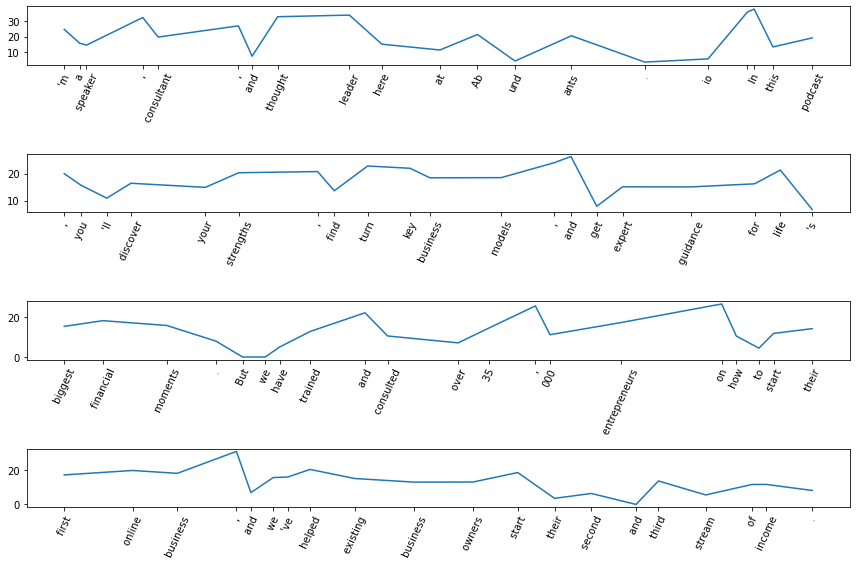

In [60]:
snippetDf1 = transcriptDf[20:40]
snippetDf2 = transcriptDf[40:60]
snippetDf3 = transcriptDf[60:80]
snippetDf4 = transcriptDf[80:100]
dfList = [snippetDf1, snippetDf2, snippetDf3, snippetDf4]

fig, ax = plt.subplots(4, 1, figsize=(12, 8))

for i in range(4): 
    snippetDf = dfList[i]
    ax[i].plot(snippetDf["start"], snippetDf["F0semitoneFrom27.5Hz_sma3nz"])
    ax[i].set_xticks(snippetDf["start"])
    ax[i].set_xticklabels(snippetDf["content"], rotation=65)

plt.tight_layout()

In [65]:
transcriptDf[["index", "start", "content", "end", "speaker", "F0semitoneFrom27.5Hz_sma3nz", "F1frequency_sma3nz"]]

,index,start,content,end,speaker,F0semitoneFrom27.5Hz_sma3nz,F1frequency_sma3nz
0,0,0.00,,3.01,,12.869793,580.875059
1,1,3.01,Welcome,4.08,SPEAKER_01,26.235128,744.916366
2,2,4.08,to,4.26,SPEAKER_01,35.202250,719.127362
3,3,4.26,the,4.53,SPEAKER_01,20.692628,660.734762
4,4,4.53,Ab,4.64,SPEAKER_01,28.512727,440.443358
...,...,...,...,...,...,...,...
4006,4006,920.24,Thank,920.53,SPEAKER_01,23.395621,415.602456
4007,4007,920.53,you,920.70,"SPEAKER_01,SPEAKER_00",18.975653,818.880993
4008,4008,920.70,so,920.81,SPEAKER_00,33.459077,657.040308
4009,4009,920.81,much,921.04,SPEAKER_00,27.940496,659.028673


In [64]:
transcriptDf.columns

Index(['index', 'start', 'end', 'content', 'speaker', 'Loudness_sma3',
       'alphaRatio_sma3', 'hammarbergIndex_sma3', 'slope0-500_sma3',
       'slope500-1500_sma3', 'spectralFlux_sma3', 'mfcc1_sma3', 'mfcc2_sma3',
       'mfcc3_sma3', 'mfcc4_sma3', 'F0semitoneFrom27.5Hz_sma3nz',
       'jitterLocal_sma3nz', 'shimmerLocaldB_sma3nz', 'HNRdBACF_sma3nz',
       'logRelF0-H1-H2_sma3nz', 'logRelF0-H1-A3_sma3nz', 'F1frequency_sma3nz',
       'F1bandwidth_sma3nz', 'F1amplitudeLogRelF0_sma3nz',
       'F2frequency_sma3nz', 'F2bandwidth_sma3nz',
       'F2amplitudeLogRelF0_sma3nz', 'F3frequency_sma3nz',
       'F3bandwidth_sma3nz', 'F3amplitudeLogRelF0_sma3nz'],
      dtype='object')